##### Installing required libararies

In [127]:
!pip install transformers numpy pandas matplotlib nltk wordcloud

Importing here all necessary librarie

In [128]:
import pandas as pd
import re
import numpy as np
from sklearn.manifold import TSNE
from transformers import AutoTokenizer, AutoModel
import torch
from sklearn.metrics.pairwise import cosine_similarity
from nltk.tokenize import word_tokenize
import nltk
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud

through pandas accessing database

In [129]:
df = pd.read_csv("/content/advices_assignment.csv")

Removing duplicates from the advice column

In [130]:
df = df.drop_duplicates(subset=['advice'])

Dropping null values

In [131]:
df = df.dropna(subset=['advice'])

First 10 rows of advice column

In [132]:
df.head(10)

,advice
0,"['Drink plenty of water', 'eat hot food']"
1,"['avoid oily and spicy foods', 'take steam thr..."
3,['ors ']
5,"['eat hot food', 'normal regular diet ', 'all ..."
6,"['Take Rest', 'Drink plenty of water', 'monito..."
7,"['Steam inhalation 4x a day', 'Monitor BP, SPO..."
8,"['avoid oily and spicy foods', 'salt water gar..."
9,"['Eat khicdi', 'Drink coconut water', 'Avoid t..."
10,"['Take Rest', 'Drink plenty of water', 'take s..."
11,"['avoid oily and spicy foods', 'take steam thr..."


In [133]:
df.columns

Index(['advice'], dtype='object')

In [134]:
df.nunique()

advice    5000
dtype: int64

In [135]:
df.isnull().sum()

advice    0
dtype: int64

In [136]:
df.describe()

,advice
count,5000
unique,5000
top,"['Drink plenty of water', 'eat hot food']"
freq,1


cleaning the data: removing punctuations

In [137]:
def clean_text(text):
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text


df['cleaned_advice'] = df['advice'].apply(clean_text)
advice_corpus = df['cleaned_advice'].tolist()


In [138]:
advice_corpus

['Drink plenty of water eat hot food',
 'avoid oily and spicy foods take steam thrice a day for seven days check SpO2 levels every 4 hrs Drink plenty of water',
 'ors',
 'eat hot food normal regular diet all foods can be given use mask social distancing isolation for 14 days warm water sips monitor spo2 regularly every 4th hourly do breathing exercises Take Rest Drink plenty of water',
 'Take Rest Drink plenty of water monitor spo2 steam inhalation',
 'Steam inhalation 4x a day Monitor BP SPO2 and Temperature every 6 hours Consult a physician if fever persists BP goes below 10050 or SPO2 drops below 95 Consult if you develop any other symptoms To contact physican if you develop fever or cough Lie in Prone Position 24 hours 48 times a day Continue Routine medication for Comorbidities if any Drink warm fluids like soup ginger teakhada etc Take Rest Avoid physical exertion Strenuous Exercise',
 'avoid oily and spicy foods salt water gargles',
 'Eat khicdi Drink coconut water Avoid travell

Here, I'm using tokenizer from BERT model

In [139]:
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

Here, I'm performing basic statistics on advice_corpus data

In [140]:
num_documents = len(advice_corpus)
document_lengths = [len(tokenizer.tokenize(text)) for text in advice_corpus]

print(f"Number of documents: {num_documents}")
print(f"Average document length: {np.mean(document_lengths):.2f}")
print(f"Minimum document length: {np.min(document_lengths)}")
print(f"Maximum document length: {np.max(document_lengths)}")

Number of documents: 5000
Average document length: 20.78
Minimum document length: 0
Maximum document length: 419


In [141]:
all_tokens = [token for text in advice_corpus for token in tokenizer.tokenize(text.lower())]

Counting most frequent words in advice_corpus data

In [142]:
word_freq = Counter(all_tokens)
print("Most frequent words:", word_freq.most_common(10))

Most frequent words: [('water', 3064), ('of', 2277), ('avoid', 2065), ('and', 1886), ('drink', 1791), ('plenty', 1729), ('take', 1689), ('##s', 1591), ('for', 1544), ('in', 1526)]


making word cloud based on word frequency

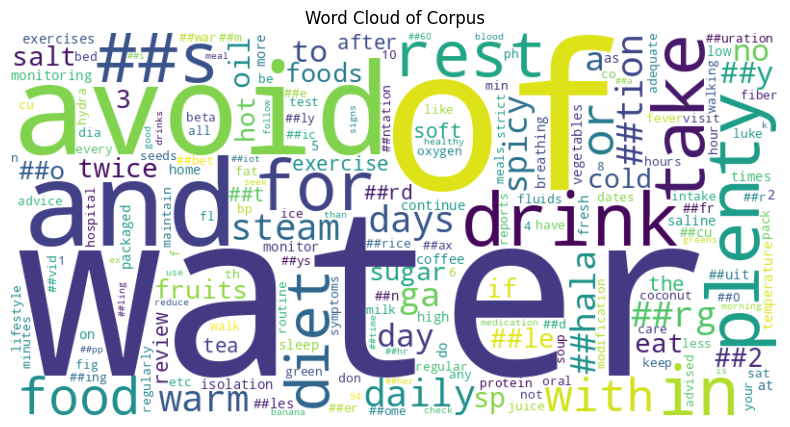

In [143]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Corpus')
plt.show()

Here, I'm creating functions for easy to create embeddings for both query and advice_corpus



In [144]:
def create_embedding(text):
    tokenized_text = tokenizer(text, return_tensors="pt")
    with torch.no_grad():
        output = model(**tokenized_text)
    return output.last_hidden_state.mean(dim=1).squeeze().numpy()

In [145]:
def create_corpus_embeddings(corpus):
    embeddings = []
    for text in corpus:
        embeddings.append(create_embedding(text))
    return np.array(embeddings)

Here, I have created this function to retrieve top 10 matches using cosine similarity property¶

In [146]:
def retrieve_top_matches(query_embedding, corpus_embeddings, top_k=10):
    similarities = cosine_similarity([query_embedding], corpus_embeddings).flatten()
    top_indices = similarities.argsort()[-top_k:][::-1]
    return top_indices, similarities[top_indices]

Here, I'm visualizing embeddings in 2 dimensional space

In [147]:
def visualize_embeddings_tsne(embeddings):
    embedding_array = np.array(embeddings)
    reduced_embeddings_tsne = TSNE(n_components=2).fit_transform(embedding_array)
    plt.scatter(reduced_embeddings_tsne[:, 0], reduced_embeddings_tsne[:, 1], c='blue')
    plt.title('t-SNE Visualization of Embeddings')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.show()

In [148]:
corpus = advice_corpus

Here, I'm generating embeddings for advice corpus data

In [149]:
corpus_embeddings = create_corpus_embeddings(corpus)

Here, I'm visualizing the embeddings in 2-D space

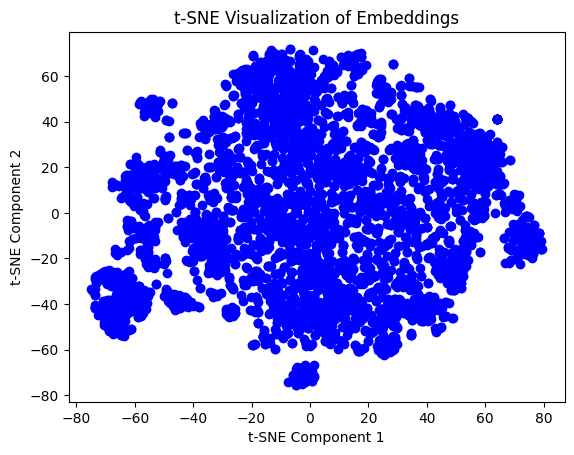

In [150]:
visualize_embeddings_tsne(corpus_embeddings)

Here, I'm asking query

In [151]:
query = "I'm tired in less work?"

creating embeddings for query text

In [152]:
query_embedding = create_embedding(query)

Here, I'm retrieving top 10 matches related to query in advice_copus

In [153]:
top_indices, similarities = retrieve_top_matches(query_embedding, corpus_embeddings)

In [154]:
for idx, sim in zip(top_indices, similarities):
    print(f"Similarity: {sim:.4f} - {corpus[idx]}")

Similarity: 0.6595 - use less computer sleep on time
Similarity: 0.6556 - Do exercise in the morning
Similarity: 0.6515 - use less computer sleep on time eat khichdi
Similarity: 0.6430 - use less computer eat khichdi
Similarity: 0.6357 - Home isolation for a week suggested
Similarity: 0.6352 - sleep more Take Rest less stress
Similarity: 0.6343 - avoid junk food
Similarity: 0.6343 - Avoid junk food
Similarity: 0.6180 - Avoid pain killers
Similarity: 0.6165 - Dressing every day under doctors observation
